### Project Code for ECE 532 project

Evan Linck

There are three algorithms that are used in this project: LASSO regression, K-nearest neigbhors, and neural nets

In [468]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
pd.set_option('display.max_columns', None)
import time

### Read in data and standardize for algorithms

Data was preprocessed in the FeatureExtraction file

In [343]:
with open("allfeatures.csv") as f:
    data = pd.read_csv(f)
IDS = data['ID'] #drop ID from matrix
data = data.drop("ID",axis=1)

Group different types of stars together. The listing of each type of star is below. Labels are from here: http://faculty.washington.edu/ivezic/sdss/catalogs/S82variables.html

data['temp_cl'].loc[data['cl']=='unknown']='unknown'<br>
data['temp_cl'].loc[data['cl']=='QSO']='QSO' #variable quasars<br>
data['temp_cl'].loc[data['cl']=='del_scu']='del_scu' #delta scuti variables<br>
data['temp_cl'].loc[data['cl']=='EC']='EC' #Contact binaries in ASAS-3<br>
data['temp_cl'].loc[data['cl']=='ED']='ED' #Detached eclipsing binaries<br>
data['temp_cl'].loc[data['cl']=='ESD']='ESD' #Semi-detached eclipsing binaries<br>
data['temp_cl'].loc[data['cl']=='EC/ESD']='EC/ESD'<br>
data['temp_cl'].loc[data['cl']=='ESD/ED']='ESD/ED'<br>
data['temp_cl'].loc[data['cl']=='EC*']='EC*'<br>
data['temp_cl'].loc[data['cl']=='ED*']='ED*'<br>
data['temp_cl'].loc[data['cl']=='mult']='mult'<br>
data['temp_cl'].loc[data['cl']=='ew']='ew' #W Ursae Majoris-type eclipsing variables<br>
data['temp_cl'].loc[data['cl']=='ea']='ea' #beta Persei-type (Algol) eclipsing systems<br>
data['temp_cl'].loc[data['cl']=='eb']='eb' #beta Lyrae-type eclipsing systems<br>
data['temp_cl'].loc[data['cl']=='rr_ab']='rr_ab' #RR Lyrae variables with asymmetric light curves<br>
data['temp_cl'].loc[data['cl']=='rr_c']='rr_c' #RR Lyrae variables with nearly symmetric<br>
data['temp_cl'].loc[data['cl']=='rr_d']='rr_d' #Double-mode RR Lyrae stars which pulsate...<br>
data['temp_cl'].loc[data['cl']=='bl']='bl' #RR Lyrae stars showing the Blazhko effect.<br>
data['temp_cl'].loc[data['cl']=='rs']='rs' #non-eclipsing RS CVn stars<br>
data['temp_cl'].loc[data['cl']=='acep']='acep' #Anomalous Cepheids<br>
data['temp_cl'].loc[data['cl']=='cep-ii']='cep-ii' ####need to confirm which star this is...<br>
data['temp_cl'].loc[data['cl']=='hads']='hads' #High Amplitude delta Scuti stars<br>
data['temp_cl'].loc[data['cl']=='lads']='lads' #low-amplitude delta Scuti stars<br>
data['temp_cl'].loc[data['cl']=='lpv']='lpv' #Long Period Variables <br>
data['temp_cl'].loc[data['cl']=='ell']='ell' #ellipsoidal binary system<br>
data['temp_cl'].loc[data['cl']=='hump']='hump' #LPV Humps<br>
data['temp_cl'].loc[data['cl']=='pceb']='pceb' #post common envelope binary planetary system<br>
data['temp_cl'].loc[data['cl']=='ea_up']='ea_up' <br>
data['temp_cl'].loc[data['cl']=='RRAB']='rr_ab' #RR Lyrae variables with asymmetric light curves<br>
data['temp_cl'].loc[data['cl']=='RRmf']='rr_mf'<br>
data['temp_cl'].loc[data['cl']=='RRC']='rr_c' #RR Lyrae variables with nearly symmetric<br>
data['temp_cl'].loc[data['cl']=='RRdm']='rr_dm' #Detached main-sequence systems?<br>
data['temp_cl'].loc[data['cl']=='RRu']='rr_u'

In [64]:
data.at[data['category'].isin(['EC','EC*', 'EC/ESD', 'ED', 'ED*' ,'ESD', 'ESD/ED']),'numcategory']=0
data.at[data['category'].isin(['ea' ,'eb','ew']),'numcategory']=1
data.at[data['category'].isin(['QSO']),'numcategory']=2
data.at[data['category'].isin(['rr_ab', 'rr_c', 'rr_dm', 'rr_mf', 'rr_u']),'numcategory']=3
data.at[data['category'].isin(['del_scu']),'numcategory']=4
data.at[data['category'].isin(['rs','lpv', 'mult']),'numcategory']=5

####  Standardize and group for cross validation

In [65]:
from sklearn.preprocessing import StandardScaler
standardized = data.replace(np.nan, 0).fillna(0.0).replace(np.inf,10**6).iloc[:,:-2].copy()
a=StandardScaler().fit_transform(standardized)
labels = data.iloc[:,-2:]
standardized = pd.DataFrame(a,columns=data.iloc[:,:-2].columns)
standardized=pd.concat([standardized,labels],axis=1)

#Split by category
eclipse = standardized.loc[data['numcategory']==0]
eclipsevariable = standardized.loc[data['numcategory']==1]
QSO = standardized.loc[data['numcategory']==2].iloc[0:527]#grab 527 QSO objects
rr =  standardized.loc[data['numcategory']==3]
del_scu = standardized.loc[data['numcategory']==4]
other = standardized.loc[data['numcategory']==5]

#split each category into 5 equal parts
ec = np.array_split(eclipse, 5)
ecv = np.array_split(eclipsevariable, 5)
qs = np.array_split(QSO, 5)
r = np.array_split(rr, 5)
ds = np.array_split(del_scu, 5)
ot = np.array_split(other, 5)

#create 5 groups for cross-validation
groups = {}
labels = {}

for i in range(5):
    frames = [ec[i],ecv[i],qs[i],r[i],ds[i],ot[i]]
    groups[i] = pd.concat(frames,axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
    labels[i] = groups[i]['numcategory'].values

#### LASSO 

In [469]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from itertools import combinations #for cross validation
lst = [0,1,2,3,4]

alphas = np.logspace(-4,1,50) #test alphas from 10^-4 to 10

errors = []
t = []
for alpha in alphas:
    errors.append([])
    for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
        t0 = time.time()
        othernum = sum(lst)-sum(combo)
        model = Lasso(alpha = alpha, max_iter=10000)
        test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True).to_numpy()[:,:-2].astype(np.float64)
        label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
        model.fit(test, label)
        errors[-1].append(model.score(groups[othernum].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
        t.append(time.time()-t0)
avgerror = np.apply_along_axis(np.mean,1,np.array(errors))

0.010124578475952148

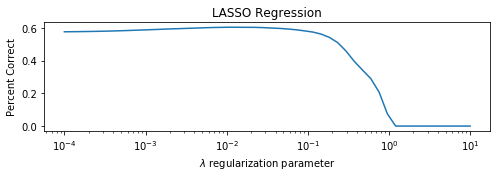

In [366]:
fig,ax = plt.subplots(figsize=(8,2))
ax.plot(alphas,avgerror)
ax.set_xscale('log')
ax.set_xlabel("$\lambda$ regularization parameter")
ax.set_ylabel("Percent Correct")
ax.set_title("LASSO Regression")

plt.savefig("lasso.png",bbox_inches='tight')

In [370]:
#Find important features
model = Lasso(alpha = alphas[avgerror.argmax()])
test = pd.concat([groups[0],groups[1],groups[2],groups[3],groups[4]],axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True).to_numpy()[:,:-2].astype(np.float64)
label = np.concatenate([labels[0],labels[1],labels[2],labels[3],labels[4]]).ravel()
model.fit(test, label)
importance = np.abs(model.coef_)
idx_features = (-importance).argsort()[:7]
name_features = np.array(feature_names)[idx_features]

name_features=np.array(feature_names)[np.where(importance>1e-8)]
print('Selected features: {}'.format(name_features))
len(name_features)

Selected features: ['Amplitude' 'Autocor_length' 'Beyond1Std' 'CAR_mean' 'CAR_sigma' 'Color'
 'Eta_e' 'FluxPercentileRatioMid20' 'FluxPercentileRatioMid65'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_2'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_rel_phase_1' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_rel_phase_3' 'LinearTrend' 'MaxSlope' 'Mean' 'MedianBRP'
 'PercentAmplitude' 'Period_fit' 'Psi_eta' 'Q31_color' 'Rcs' 'Skew'
 'SlottedA_length' 'SmallKurtosis' 'StetsonK' 'StetsonK_AC']


30

### KNN

In [489]:
from sklearn.neighbors import KNeighborsClassifier

errors = []
t=[]
for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
    t0 = time.time()
    othernum = sum(lst)-sum(combo)
    model = KNeighborsClassifier(n_neighbors=10)
    test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True)[name_features[:25]].to_numpy()[:,:-2].astype(np.float64)
    label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
    model.fit(test, label)
    errors.append(model.score(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
    #print(np.where(model.predict(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64))>4))
    t.append(time.time()-t0)
np.average(t)

0.0250521183013916

In [462]:
np.mean(errors)

0.8850620658345616

Text(0.5, 1.0, 'Clusters of objects based on two important features')

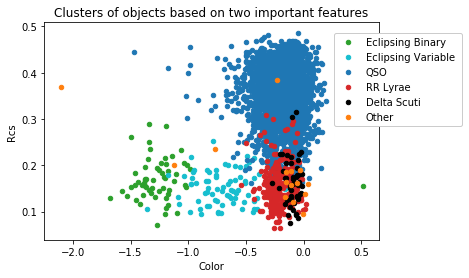

In [490]:
fig, ax = plt.subplots()

for i in range(1,7):
    colors=['tab:green','tab:cyan','tab:blue','tab:red','k','tab:orange']
    lab = ['Eclipsing Binary',
        'Eclipsing Variable ',
        'QSO' ,
        'RR Lyrae',
        'Delta Scuti' ,
        'Other' ]
    data.loc[data.numcategory ==(i-1)].plot.scatter(x='Color',y='Rcs',c=colors[i-1], ax=ax,label=lab[i-1])
ax.legend(bbox_to_anchor=(.85, 0.5),framealpha=1)
ax.set_title("Clusters of objects based on two important features")
fig.savefig("knn.png", bbox_inches='tight')

### Neural Net

In [219]:
#create lists of number of nodes and layers for both the breadth and depth searches
nodes = np.linspace(1,150, 15,dtype=int)

params = []
params2 = []
params3 = []
for i in nodes:
    params.append(tuple([i]))
for i in params:
    for n in nodes:
        params2.append((i[0],n))
for i in params:
    for m in params:
        for n in nodes:
            params3.append((i[0],m[0],n))

params.extend(params2)
params.extend(params3)            
            
params1 = []
for i in np.linspace(1,300, 150,dtype=int):
    params1.append(tuple([i]))

array([  1,  11,  22,  32,  43,  54,  64,  75,  86,  96, 107, 118, 128,
       139, 150])

In [493]:
#run NN for depth search. Change loop to over "params" for breadth search

from sklearn.neural_network import MLPClassifier

errors = []


alphas = np.logspace(-4,1,50)

errors = []
count =0
t=[]
for param in params1:
    errors.append([])
    if count %50 ==0:
        print(count)
    count+=1
    
    for combo in combinations(lst, 4):  # 2 for pairs, 3 for triplets, etc
        t0 = time.time()
        othernum = sum(lst)-sum(combo)
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=param, random_state=1)
        test = pd.concat([groups[combo[0]],groups[combo[1]],groups[combo[2]],groups[combo[3]]],axis=0, join='outer', ignore_index=True, keys=None,
                  levels=None, names=None, verify_integrity=False, copy=True)[name_features[:25]].to_numpy()[:,:-2].astype(np.float64)
        label = np.concatenate([labels[combo[0]],labels[combo[1]],labels[combo[2]],labels[combo[3]]]).ravel()
        model.fit(test, label)
        errors[-1].append(model.score(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64),labels[othernum]))
        t.append(time.time()-t0)

        #         print(np.where(model.predict(groups[othernum][name_features[:25]].to_numpy()[:,:-2].astype(np.float64))>4))
print(np.mean(t))
avgerror = np.apply_along_axis(np.mean,1,np.array(errors))

0
50
100
0.07243858814239502


In [494]:
#identify most accurate and number of nodes and layers that produce them
idx_features = (-avgerror).argsort()[:150]
print(np.array(avgerror)[idx_features])
np.array(params1)[idx_features]

[0.92635378 0.92119228 0.91982752 0.9198261  0.91977571 0.91850193
 0.91731337 0.91731326 0.91731283 0.91730401 0.91729618 0.91727909
 0.9172201  0.91716089 0.91604808 0.91604786 0.9160225  0.9160224
 0.91601412 0.91600585 0.91600585 0.91600531 0.9160052  0.91598822
 0.91598093 0.91592945 0.91591302 0.91475754 0.91473229 0.91472413
 0.91469834 0.91469834 0.91468169 0.91463086 0.9146055  0.91346711
 0.9134176  0.91341639 0.91339092 0.91335817 0.91335719 0.91335719
 0.91331452 0.91327328 0.91218473 0.91214261 0.9121339  0.91210898
 0.9121006  0.9121006  0.91208395 0.9120673  0.91205892 0.91205065
 0.91205011 0.91203247 0.91200766 0.91091922 0.91090257 0.91089441
 0.91086883 0.91086056 0.91081017 0.91081006 0.91080201 0.91080135
 0.91079385 0.91077643 0.910776   0.91068305 0.90957905 0.90955369
 0.90952834 0.90952039 0.90949449 0.90949438 0.90946064 0.90945237
 0.90942691 0.90828808 0.90825489 0.90824607 0.90822126 0.90822126
 0.90822115 0.9082206  0.90821288 0.90820395 0.90819579 0.90817

array([[155],
       [207],
       [165],
       [251],
       [161],
       [249],
       [285],
       [237],
       [257],
       [291],
       [203],
       [269],
       [229],
       [235],
       [211],
       [107],
       [ 83],
       [267],
       [131],
       [221],
       [199],
       [177],
       [233],
       [217],
       [201],
       [145],
       [273],
       [261],
       [277],
       [129],
       [281],
       [183],
       [241],
       [209],
       [265],
       [ 45],
       [ 33],
       [271],
       [287],
       [169],
       [219],
       [189],
       [193],
       [147],
       [275],
       [109],
       [297],
       [171],
       [151],
       [187],
       [279],
       [300],
       [103],
       [ 31],
       [153],
       [105],
       [111],
       [115],
       [197],
       [223],
       [231],
       [289],
       [ 75],
       [117],
       [245],
       [215],
       [125],
       [239],
       [139],
       [263],
       [259],
      

In [337]:
#results for breadth search
print(np.array(params)[idx_features])
np.array(avgerror)[idx_features]

[(32, 128, 32) (22, 43, 86) (118, 22, 150) (107, 86, 32) (139, 43, 107)
 (43, 96, 54) (96, 118, 150) (107, 139, 118) (139, 75, 75) (150, 64, 54)
 (150, 107, 96) (107, 139, 54) (32, 75) (150, 107, 64) (150, 139, 128)
 (139, 11, 22) (64, 43, 96) (128, 32, 96) (43, 150, 150) (54, 150, 86)
 (107, 107, 118) (107, 86, 107) (64, 128, 43) (43, 128, 64) (64, 107, 54)
 (43, 75, 118) (54, 54, 96) (107, 150, 118) (96, 75, 22) (64, 54, 43)
 (139, 118, 64) (118, 86, 32) (64,) (118, 139, 75) (128, 139, 86)
 (107, 150, 86) (139, 22, 150) (96, 118, 107) (139, 75, 107)
 (107, 118, 150) (107, 118, 128) (96, 75, 128) (128, 96, 64) (64, 75, 139)
 (128, 64, 139) (96, 107, 43) (150, 75, 64) (86, 43, 54) (43, 86, 96)
 (107, 96, 107)]


array([0.92376629, 0.9236395 , 0.92249044, 0.92246704, 0.92234809,
       0.9212011 , 0.92119283, 0.92115953, 0.92112579, 0.92109205,
       0.91991948, 0.91986822, 0.91986039, 0.91985201, 0.91983492,
       0.91981   , 0.91978464, 0.91975896, 0.91970084, 0.91863754,
       0.91861197, 0.91860468, 0.91860282, 0.91858704, 0.91856179,
       0.91855298, 0.91855232, 0.91853622, 0.91852849, 0.91852707,
       0.91851913, 0.91850259, 0.9185015 , 0.91848594, 0.91736321,
       0.91734722, 0.91732197, 0.91731326, 0.91730521, 0.91729683,
       0.9172879 , 0.91726277, 0.91726255, 0.91726244, 0.91725439,
       0.91724644, 0.91724579, 0.91723806, 0.91723719, 0.91722958])

Graph

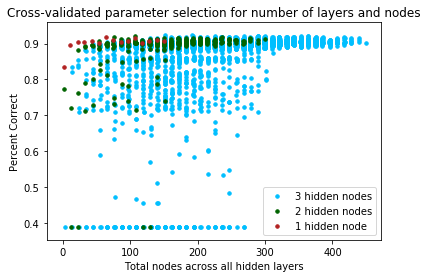

In [335]:
x1 = np.asarray(params[0:len(params1)])
x2 = np.asarray(params[len(params1):(len(params2)+len(params1))])
x3 = np.asarray(params[(len(params2)+len(params1)):])
x1 = np.apply_along_axis(sum,1,x1)
x2 = np.apply_along_axis(sum,1,x2)
x3 = np.apply_along_axis(sum,1,x3)

y1 = avgerror[0:len(params1)]
y2 = avgerror[len(params1):(len(params2)+len(params1))]
y3 = avgerror[(len(params2)+len(params1)):]

fig,ax= plt.subplots()

ax.scatter(x3,y3,c='deepskyblue',s=12,label='3 hidden nodes')

ax.scatter(x=x2,y=y2,c='darkgreen',s=12,label='2 hidden nodes')
ax.scatter(x=x1,y=y1,c='firebrick',s=12,label='1 hidden node')
ax.legend()
ax.set_xlabel("Total nodes across all hidden layers")
ax.set_ylabel("Percent Correct")
ax.set_title("Cross-validated parameter selection for number of layers and nodes")
plt.savefig("NN_CV_params.png",bbox_inches='tight')